In [1]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA

import os

import numpy as np
from astropy.table import Table
import astropy.units as u
from scipy.stats import gamma
import matplotlib.pyplot as plt
import matplotlib as mpl

from snewpy import model_path
from snewpy.neutrino import Flavor
from snewpy.models.ccsn import Analytic3Species

from asteria.simulation import Simulation

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


In [2]:
filename = "GenericFlatLightCurve.dat"
model_folder = f"{model_path}/AnalyticFluence/"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)
file_path = os.path.join(model_folder, filename)
print(file_path)

/home/jakob/.astropy/cache/snewpy/models/AnalyticFluence/GenericFlatLightCurve.dat


In [3]:
def luminosity_nue(t):
    # 1st Gaussian for deleptonization
    gaussian_00 = np.exp(-((t - 0.01) / 0.05)**2) * 4e53  # Amplitude 1e53, centered at 50 ms

    # 2nd Gaussian for shock stagnation (electron + positron capture)
    gaussian_01 = np.exp(-((t - 0.1) / 0.5)**2) * 6e52  # Amplitude 1e53, centered at 50 ms

    # Flat component
    flat = np.ones_like(t) * 3e52  # Flat at 1e52 from 50 ms to 500 ms
    
    # Power-law component
    power_law = 2e52 / (t+0.5)  # Power-law decay beyond 500 ms

    # Fermi-Dirac transition between gaussian and flat
    transition_00 = 1 / (1 + np.exp((0.005 - t) * 1000)) # Smooth transition between 0 and 1

    # Fermi-Dirac transition between gaussian and flat
    transition_01 = 1 / (1 + np.exp((t - 0.07) * 50)) # Smooth transition between 0 and 1

    # Fermi-Dirac transition between gaussian and flat
    transition_02 = 1 / (1 + np.exp((t - 0.2) * 100))  # Smooth transition between 0 and 1
    
    # Fermi-Dirac transition between flat and power-law
    transition_05 = 1 / (1 + np.exp((t - 0.5) * 50))  # Smooth transition between 0 and 1
    
    #return gaussian * (1 - transition) + flat * transition + power_law * transition
    lumi_nue = gaussian_00 * ((transition_00 + transition_01)-1) + gaussian_01 * ((1-transition_01 + transition_02)-1) + flat * ((1-transition_02 + transition_05)-1) + power_law * (1-transition_05)

    return lumi_nue

def luminosity_nue_bar(t):
    # Similar to nu-e but without the deleptonization component

    gaussian_01 = np.exp(-((t - 0.1) / 0.5)**2) * 6e52  # Amplitude 1e53, centered at 50 ms
    flat = np.ones_like(t) * 3e52  # Flat at 1e52 from 50 ms to 500 ms
    power_law = 2e52 / (t+0.5)  # Power-law decay beyond 500 ms
    transition_01 = 1 / (1 + np.exp((t - 0.07) * 50)) # Smooth transition between 0 and 1
    transition_02 = 1 / (1 + np.exp((t - 0.2) * 100))  # Smooth transition between 0 and 1
    transition_05 = 1 / (1 + np.exp((t - 0.5) * 50))  # Smooth transition between 0 and 1

    lumi_nuebar = gaussian_01 * ((1-transition_01 + transition_02)-1) + flat * ((1-transition_02 + transition_05)-1) + power_law * (1-transition_05)

    return lumi_nuebar


def luminosity_nux(t):

    gaussian_01 = np.exp(-((t - 0.1) / 0.5)**2) * 3e52  # Amplitude 1e53, centered at 50 ms
    power_law = 2e52 / (t+0.8)  # Power-law decay beyond 500 ms
    transition_01 = 1 / (1 + np.exp((t - 0.07) * 50)) # Smooth transition between 0 and 1
    transition_02 = 1 / (1 + np.exp((t - 0.2) * 100))  # Smooth transition between 0 and 1

    lumi_nux = gaussian_01 * ((1-transition_01 + transition_02)-1) + power_law * (1-transition_02)

    return lumi_nux

def mean_energy(t):
    # Mean energy increases from 10 MeV to 20 MeV between 0 ms to 500 ms, then remains constant
    # No flavour dependency considered
    linear1 = 10 + 5 * t/0.5
    linear2 = 145/9 - 10/9*t  # linear from 1 s to 10 s, with E(1s) = 15 MeV, E(10s) = 5 MeV
    flat = np.ones_like(t) * 15
    transition1 = 1 / (1 + np.exp((t - 0.5) * 20)) # Smooth transition between 0 and 1
    transition2 = 1 / (1 + np.exp((t - 1) * 20)) 

    mean_energy = linear1 * transition1 + ((1-transition1 + transition2)-1) * flat + (1-transition2) * linear2

    return mean_energy

def alpha(t):
    # Pinching parameter alpha, consider constant value of 2.7 over time for all neutrino flavours
    linear = -1.6 * t + 3.5 # alpha(0) = 3.5, alpha(0.5s) = 2.7, t > 0.5 s flat
    flat = np.ones_like(t)*2.7
    transition = 1 / (1 + np.exp((t - 0.5) * 20)) # Smooth transition between 0 and 1

    alpha = linear * transition + flat * (1-transition) 

    return alpha 

def energy_spectrum(E, t):
    # Energy spectrum resem
    Em = mean_energy(t)
    a = alpha(t)
    spectrum = E**(a) * np.exp(-(a+1)*E/Em) 
    
    #return gamma.pdf(E, a=2, loc=0, scale=mean_energy / 2)
    return spectrum/(np.sum(spectrum)*(E[1]-E[0]))

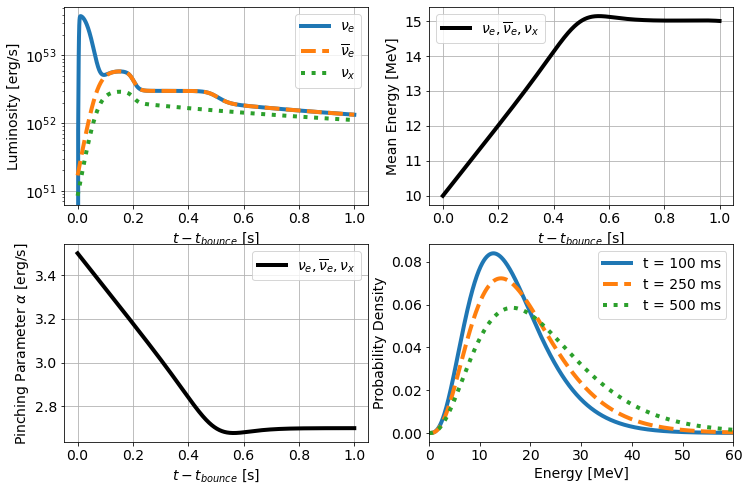

In [4]:
# Generate time array
time = np.linspace(0, 1, 1000)  # Time from 0 to 1 s
energy = np.linspace(0, 40, len(time))

# Calculate luminosities and energy spectra
luminosity_nue_values = luminosity_nue(time)
luminosity_nue_bar_values = luminosity_nue_bar(time)
luminosity_nux_values = luminosity_nux(time)
mean_energy_values = mean_energy(time)
alpha_values = alpha(time)
energy_spectrum_values = energy_spectrum(energy, 0.6)


# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time, luminosity_nue_values, color = "C0", ls = "-", lw = 4, label=r'$\nu_e$')
plt.plot(time, luminosity_nue_bar_values, color = "C1", ls = "--", lw = 4, label=r'$\overline{\nu}_e$')
plt.plot(time, luminosity_nux_values, color = "C2", ls = ":", lw = 4, label=r'$\nu_x$')
plt.xlabel(r'$t-t_{{bounce}}$ [s]', fontsize=14)
plt.ylabel('Luminosity [erg/s]', fontsize=14)
#plt.xlim(0,1)
#plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, mean_energy_values, color = "k", ls = "-", lw = 4, label = r'$\nu_e, \overline{\nu}_e, \nu_x$')
plt.xlabel(r'$t-t_{{bounce}}$ [s]', fontsize=14)
plt.ylabel('Mean Energy [MeV]', fontsize=14)
#plt.xlim(0,1)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(time, alpha_values, color = "k", ls = "-", lw = 4, label = r'$\nu_e, \overline{\nu}_e, \nu_x$')
plt.xlabel(r'$t-t_{{bounce}}$ [s]', fontsize=14)
plt.ylabel(r'Pinching Parameter $\alpha$ [erg/s]', fontsize=14)
#plt.xlim(0,1)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(np.linspace(0, 60, len(time)), energy_spectrum(energy, 0.1), color = "C0", ls = "-", lw = 4, label = "t = 100 ms")
plt.plot(np.linspace(0, 60, len(time)), energy_spectrum(energy, 0.25), color = "C1", ls = "--", lw = 4, label = "t = 250 ms")
plt.plot(np.linspace(0, 60, len(time)), energy_spectrum(energy, 0.5), color = "C2", ls = ":", lw = 4, label = "t = 500 ms")
plt.xlabel('Energy [MeV]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(0,60)
#plt.yscale("log")
#plt.tight_layout()
plt.legend(fontsize=14)
plt.show()

/tmp/ipykernel_6923/1140604986.py:21: RuntimeWarning: overflow encountered in exp
  transition_02 = 1 / (1 + np.exp((t - 0.2) * 100))  # Smooth transition between 0 and 1
/tmp/ipykernel_6923/1140604986.py:38: RuntimeWarning: overflow encountered in exp
  transition_02 = 1 / (1 + np.exp((t - 0.2) * 100))  # Smooth transition between 0 and 1
/tmp/ipykernel_6923/1140604986.py:51: RuntimeWarning: overflow encountered in exp
  transition_02 = 1 / (1 + np.exp((t - 0.2) * 100))  # Smooth transition between 0 and 1


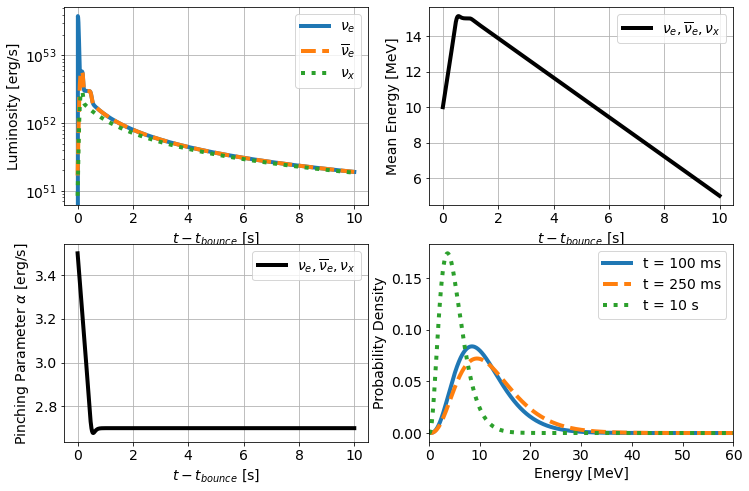

In [5]:
# Generate time array
time = np.linspace(0, 10, 1000)  # Time from 0 to 1 s
energy = np.linspace(0, 60, len(time))

# Calculate luminosities and energy spectra
luminosity_nue_values = luminosity_nue(time)
luminosity_nue_bar_values = luminosity_nue_bar(time)
luminosity_nux_values = luminosity_nux(time)
mean_energy_values = mean_energy(time)
alpha_values = alpha(time)


# Plot the results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time, luminosity_nue_values, color = "C0", ls = "-", lw = 4, label=r'$\nu_e$')
plt.plot(time, luminosity_nue_bar_values, color = "C1", ls = "--", lw = 4, label=r'$\overline{\nu}_e$')
plt.plot(time, luminosity_nux_values, color = "C2", ls = ":", lw = 4, label=r'$\nu_x$')
plt.xlabel(r'$t-t_{{bounce}}$ [s]', fontsize=14)
plt.ylabel('Luminosity [erg/s]', fontsize=14)
#plt.xlim(0,1)
#plt.xscale("log")
plt.yscale("log")
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(time, mean_energy_values, color = "k", ls = "-", lw = 4, label = r'$\nu_e, \overline{\nu}_e, \nu_x$')
plt.xlabel(r'$t-t_{{bounce}}$ [s]', fontsize=14)
plt.ylabel('Mean Energy [MeV]', fontsize=14)
#plt.xlim(0,1)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(time, alpha_values, color = "k", ls = "-", lw = 4, label = r'$\nu_e, \overline{\nu}_e, \nu_x$')
plt.xlabel(r'$t-t_{{bounce}}$ [s]', fontsize=14)
plt.ylabel(r'Pinching Parameter $\alpha$ [erg/s]', fontsize=14)
#plt.xlim(0,1)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(energy, energy_spectrum(energy, 0.1), color = "C0", ls = "-", lw = 4, label = "t = 100 ms")
plt.plot(energy, energy_spectrum(energy, 0.25), color = "C1", ls = "--", lw = 4, label = "t = 250 ms")
plt.plot(energy, energy_spectrum(energy, 10), color = "C2", ls = ":", lw = 4, label = "t = 10 s")
plt.xlabel('Energy [MeV]', fontsize=14)
plt.ylabel('Probability Density', fontsize=14)
plt.tick_params(labelsize=14)
plt.xlim(0,60)
#plt.yscale("log")
#plt.tight_layout()
plt.legend(fontsize=14)
plt.show()

In [6]:
# Generate time array
time = np.linspace(0, 1, 1001)  # Time from 0 to 1 s

# Calculate luminosities and energy spectra
lumi_nue = luminosity_nue(time)
lumi_nue_bar = luminosity_nue_bar(time)
lumi_nux = luminosity_nux(time)
en_mean = mean_energy(time)
alp = alpha(time)


rms_or_pinch = "pinch"
sr_or_hr = "hr" # hr = high resolution (42 energy bins), sr = standard resolution (21 energy bins)

# Make an astropy table with two times, 0s and 1s, with constant neutrino properties
table = Table()
table['TIME'] = time
table['L_NU_E'] =  lumi_nue
table['L_NU_E_BAR'] = lumi_nue_bar
table['L_NU_X'] = lumi_nux #Note, L_NU_X is set to 1/4 of the total NU_X energy
        
table['E_NU_E'] = en_mean
table['E_NU_E_BAR'] = en_mean
table['E_NU_X'] = en_mean

if rms_or_pinch == "rms":
    table['RMS_NU_E'] = np.linspace(1,1,bins)*rms_energy[0]
    table['RMS_NU_E_BAR'] = np.linspace(1,1,bins)*rms_energy[1]
    table['RMS_NU_X'] = np.linspace(1,1,bins)*rms_energy[2]
    table['ALPHA_NU_E'] = (2.0 * table['E_NU_E'] ** 2 - table['RMS_NU_E'] ** 2) / (
        table['RMS_NU_E'] ** 2 - table['E_NU_E'] ** 2)
    table['ALPHA_NU_E_BAR'] = (2.0 * table['E_NU_E_BAR'] ** 2 - table['RMS_NU_E_BAR'] ** 2) / (
        table['RMS_NU_E_BAR'] ** 2 - table['E_NU_E_BAR'] ** 2)
    table['ALPHA_NU_X'] = (2.0 * table['E_NU_X'] ** 2 - table['RMS_NU_X'] ** 2) / (
        table['RMS_NU_X'] ** 2 - table['E_NU_X'] ** 2)
elif rms_or_pinch == "pinch":
    table['ALPHA_NU_E'] = alp
    table['ALPHA_NU_E_BAR'] = alp
    table['ALPHA_NU_X'] = alp
    table['RMS_NU_E'] = np.sqrt((2.0 + table['ALPHA_NU_E'])/(1.0 + table['ALPHA_NU_E'])*table['E_NU_E']**2)
    table['RMS_NU_E_BAR'] =  np.sqrt((2.0 + table['ALPHA_NU_E_BAR'])/(1.0 + table['ALPHA_NU_E_BAR'])*table['E_NU_E_BAR']**2)
    table['RMS_NU_X'] = np.sqrt((2.0 + table['ALPHA_NU_X'])/(1.0 + table['ALPHA_NU_X'])*table['E_NU_X']**2 )
else:
    print("incorrect second moment method: rms or pinch")

#table.write(file_path,format='ascii',overwrite=True)

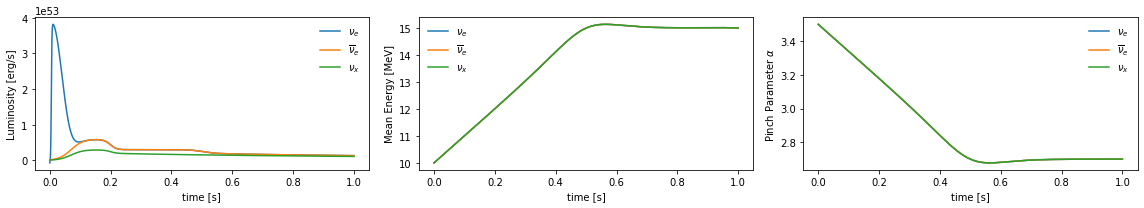

In [7]:
%matplotlib inline
filename = "GenericFlatLightCurve.dat"
model = Analytic3Species(model_folder+"./"+filename)
flavors = [Flavor.NU_E,Flavor.NU_E_BAR,Flavor.NU_X]

fig,axes = plt.subplots(1,3,figsize=(16,3))
plt.subplots_adjust(wspace=0.3)
for flavor in flavors:
    axes[0].plot(model.time,model.luminosity[flavor],label=flavor.to_tex())
axes[0].set_ylabel("Luminosity [erg/s]")
axes[0].set_xlabel("time [s]")
axes[0].legend(frameon=False)

for flavor in flavors:
    axes[1].plot(model.time,model.meanE[flavor],label=flavor.to_tex())
axes[1].set_ylabel("Mean Energy [MeV]")
axes[1].set_xlabel("time [s]")
axes[1].legend(frameon=False)

for flavor in flavors:
    axes[2].plot(model.time,model.pinch[flavor],label=flavor.to_tex())
axes[2].set_ylabel(r"Pinch Parameter $\alpha$")
axes[2].set_xlabel("time [s]")
axes[2].legend(frameon=False)

plt.tight_layout()

In [8]:
# SNEWPY model dictionary, the format must match the below example for analytic mdoels
model_generic = {
    'name': 'Analytic3Species',
    'param': {
        'filename': file_path
    }
}

sim_generic = Simulation(model=model_generic,
                 distance=10 * u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=-1*u.s,  tmax=1*u.s,    dt=1*u.ms,
                 mixing_scheme='NoTransformation',
                 hierarchy='normal')
sim_generic.run()

In [9]:
# SNEWPY model dictionary, the format must match the below example for analytic mdoels
model_tamborra = {
    'name': 'Tamborra_2014',
    'param': {
        'progenitor_mass': 27 * u.solMass,
        'direction': 3 
    }
}

sim_tamborra = Simulation(model=model_tamborra,
                 distance=10 * u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=-1*u.s,  tmax=1*u.s,    dt=1*u.ms,
                 mixing_scheme='NoTransformation',
                 hierarchy='normal')
sim_tamborra.run()

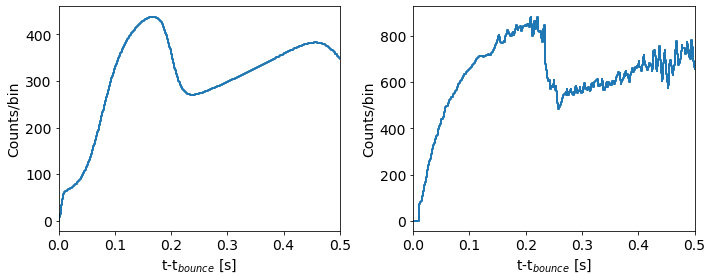

In [10]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
dt = 1 * u.ms

sim_generic.rebin_result(dt)
t_generic, hits_generic = sim_generic.detector_signal(dt)
bg = sim_generic.detector.i3_bg(dt, size=hits_generic.size) + sim_generic.detector.dc_bg(dt, size=hits_generic.size)

sim_tamborra.rebin_result(dt)
t_tamborra, hits_tamborra = sim_tamborra.detector_signal(dt)
bg_tamborra = sim_tamborra.detector.i3_bg(dt, size=hits_tamborra.size) + sim_tamborra.detector.dc_bg(dt, size=hits_tamborra.size)



ax[0].step(t_generic, hits_generic, where='post', lw=2)
ax[0].set(xlim=(0, 0.5));
ax[0].set_xlabel(r't-t$_{bounce}$ [s]', fontsize=14)
ax[0].set_ylabel(r'Counts/bin', fontsize=14)
ax[0].tick_params(labelsize=14)


ax[1].step(t_tamborra, hits_tamborra, where='post', lw=2)
ax[1].set(xlim=(0, 0.5));
ax[1].set_xlabel(r't-t$_{bounce}$ [s]', fontsize=14)
ax[1].set_ylabel(r'Counts/bin', fontsize=14)
ax[1].tick_params(labelsize=14)

plt.tight_layout()

In [33]:
def double_luminosity(lum):
    new_lum = {}
    for key, val in lum.items():
        new_lum.update({key: val*2})
    return new_lum


def osc_luminosity(instance, osc_para):
    print(instance, type(instance))
    new_lum = {}
    for key, val in instance.luminosity.items():
        new_lum.update({key: add_osc(instance, val, osc_para)})
    return new_lum

def osc_template(instance, osc_para):

    # Template parameters
    frequency = osc_para["frequency"] # osc frequency in Hz
    amplitude = osc_para["amplitude"] # osc amplitude in percentage of max. luminosity
    time_start = osc_para["time_start"] #osc start time in s
    time_end = osc_para["time_end"] #osc end time in s
    position = osc_para["position"] #osc positioning relative to start time

    # Transform all parameters in units of [s] and [1/s]
    frequency = frequency.to(1/u.s)
    dt = (instance.time[1]-instance[0]).to(u.s) # time array has to have equal step size
    time_start = time_start.to(u.s) #osc start time in s
    time_end = time_end.to(u.s) #osc end time in s
    
    # Find number of full periods that fit into the template_window
    window = time_end-time_start # osc window
    n_periods = int(window*frequency) # number of full periods
    duration = n_periods/frequency # duration of full period osc

    # Generate sinusodial signal for the template duration
    x = np.arange(0, duration.value, dt.value)*u.s
    y = np.sin(2 * np.pi * frequency * x) * amplitude # scale sinus by amplitude factor

    # Smooth signal by applying hanning window over the template duration
    y *= np.hanning(len(y))

    # Find bins corresponding to start, end and "full period" end time
    bin_start, bin_end, bin_end_new = int(time_start/dt), int(time_end/dt), int((time_start+duration)/dt) ##
    
    # prepare osc template
    bins_template = len(x) # number of bins in template
    template = np.zeros_like(instance.time.value) # empty array of tlength signal window
    template[:bins_template] = y # place template in the beginning
    
    # Template can be placed next to time_start (left), time_end (right) and in the middle between time_start and time_end_new
    if position == "center":
        bin_roll = bin_start + int((bin_end-bin_end_new)/2)
    elif position == "left":
        bin_roll = bin_start
    elif position == "right":
        bin_roll = bin_end-bins_template
    else:
        raise ValueError('{} locator does not exist. Choose from "center", "left", "right".'.format(position))
    
    # roll template in position
    template = np.roll(template, bin_roll)
    
    return template

def add_osc(instance, key, osc_para):

    #osc_par = dict(osc_para)
    # Scale amplitude relative to max light curve of IC86, Gen2
    osc_para["amplitude"] = osc_para["amplitude"] * np.max(instance.luminosity[key])


    if osc_para["time_start"] < instance.time[0]:
        raise ValueError("time_start = {} smaller than simulation time start of {}".format(osc_para["time_start"], instance.sim.time[0]))
    elif osc_para["time_end"] > instance.time[-1]:
        raise ValueError("time_end = {} larger than simulation time end of {}".format(osc_para["time_end"], instance.sim.time[-1]))
        
    template = osc_template(osc_para)
    
    # combine luminosity of flat model with oscillation template
    new_lum = instance.luminosity[key] + template
    
    # make sure that high amplitude fluctuations do not cause negative counts
    new_lum = np.maximum(new_lum, 0)
    
    return new_lum


def ModelOscExtension(model):
    """Provide an extended SNEWPY Model class
    
    Parameters
    ----------
    model : snewpy.models.SupernovaModel
        SNEWPY Model to which the extension is applied
    """
    class ExtendedModel(model):            

        # Analytic3Species models have no __new__ input function

        if model.__name__ == "Analytic3Species":

            def __init__(cls, filename):
                instance = model.__init__(cls, filename)
                #print(model.__init___(cls, filename))
                #print(instance, type(instance))
                #instance.luminosity = osc_luminosity(instance, osc_para)
                #instance.luminosity = double_luminosity(instance.luminosity)
                return instance

        else:  
            def __new__(cls, *args, **kwargs):
                instance = model.__new__(cls, *args, **kwargs)
                
                # Add your modifications to members or member functions here
                
                # Example: Double the luminosity of this model
                #instance.luminosity = double_luminosity(instance.luminosity)
                instance.luminosity = osc_luminosity(instance)
                return instance
            
    return ExtendedModel

In [34]:
# Initialize

osc_para = {"frequency": 80 * u.Hz, 
             "amplitude": 0.2,
             "time_start": 150 * u.ms,
             "time_end": 300 * u.ms,
             "position": "center"}

flat_model = Analytic3Species(file_path)
osc_model = ModelOscExtension(Analytic3Species)(filename = file_path)


TypeError: object.__new__(X): X is not a type object (ExtendedModel)

Problem: instance object for Analytic3Species class is None

Solution: Understand where None object is coming from, Spencer!